# Morphological Operations: Handling Sparse and Patchy Data

## Learning Objectives

By the end of this notebook, you will be able to:

- Understand why sparse data creates problems for spatial analysis
- Use morphological operations (dilate, fill_holes, close_gaps) to improve connectivity
- Control active bin inference with `bin_count_threshold`
- Diagnose and fix common issues with real-world position tracking data
- Make informed decisions about when to use morphological operations

**Estimated time: 20-30 minutes**

## The Problem: Real Data is Messy

In notebook 01, we worked with clean, uniformly sampled position data. But real experimental data is often:

- **Sparse**: Animals don't visit all locations equally
- **Patchy**: Tracking can fail briefly, creating gaps
- **Biased**: Animals prefer certain regions (edges, corners, goal locations)
- **Noisy**: Position estimates can be inaccurate or have outliers

These issues can fragment your environment into disconnected regions, making spatial analysis difficult or impossible.

**This notebook shows you how to handle these challenges!**

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from neurospatial import Environment

np.random.seed(42)
plt.rcParams["figure.figsize"] = (12, 10)
plt.rcParams["font.size"] = 11

## Creating Realistic Sparse Data

Let's simulate what real position tracking often looks like: an animal that prefers certain regions and avoids others.

In [2]:
def create_sparse_trajectory(n_samples=3000, seed=42):
    """
    Create sparse position data with realistic biases.

    Simulates an animal that:
    - Prefers to stay near walls (thigmotaxis)
    - Has occasional tracking failures
    - Makes quick runs across the center

    Parameters
    ----------
    n_samples : int
        Number of position samples to generate.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    position : ndarray, shape (n_samples, 2)
        2D position data in cm.
    """
    np.random.seed(seed)
    position = np.zeros((n_samples, 2))
    position[0] = [10, 10]  # Start in corner

    # Create biased random walk
    for t in range(1, n_samples):
        # Strong preference for edges
        if np.random.rand() < 0.7:  # 70% of time, move along edges
            # Move along walls
            if (
                position[t - 1, 0] < 15 or position[t - 1, 0] > 85
            ):  # Near vertical walls
                step = [np.random.randn() * 0.5, np.random.randn() * 3.0]
            elif (
                position[t - 1, 1] < 15 or position[t - 1, 1] > 85
            ):  # Near horizontal walls
                step = [np.random.randn() * 3.0, np.random.randn() * 0.5]
            else:
                step = np.random.randn(2) * 2.0
        else:  # Occasional center crossing
            step = np.random.randn(2) * 5.0

        position[t] = position[t - 1] + step
        position[t] = np.clip(position[t], 5, 95)

    # Add some tracking failures (NaN regions that get filtered out)
    tracking_failures = np.random.choice(
        n_samples, size=int(n_samples * 0.05), replace=False
    )

    # Remove tracked failures
    position = np.delete(position, tracking_failures, axis=0)

    return position


sparse_data = create_sparse_trajectory(n_samples=3000)
print(f"Generated {len(sparse_data)} position samples")
print(f"X range: [{sparse_data[:, 0].min():.1f}, {sparse_data[:, 0].max():.1f}] cm")
print(f"Y range: [{sparse_data[:, 1].min():.1f}, {sparse_data[:, 1].max():.1f}] cm")

Generated 2850 position samples
X range: [5.0, 95.0] cm
Y range: [5.0, 95.0] cm


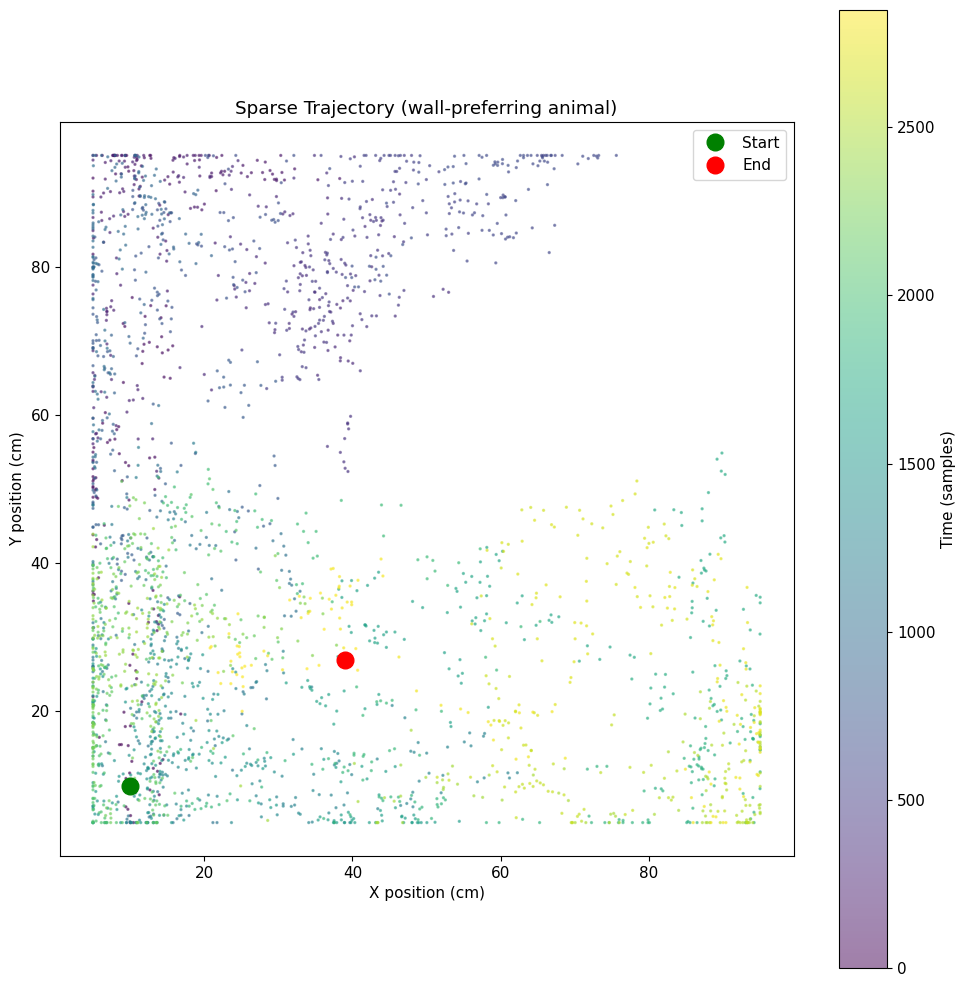


Notice: Animal spends most time near walls, rarely visits center


In [3]:
# Visualize the sparse trajectory
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    sparse_data[:, 0],
    sparse_data[:, 1],
    c=np.arange(len(sparse_data)),
    cmap="viridis",
    s=2,
    alpha=0.5,
)

ax.plot(sparse_data[0, 0], sparse_data[0, 1], "go", markersize=12, label="Start")
ax.plot(sparse_data[-1, 0], sparse_data[-1, 1], "ro", markersize=12, label="End")

ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Sparse Trajectory (wall-preferring animal)")
ax.set_aspect("equal")
ax.legend()
plt.colorbar(scatter, ax=ax, label="Time (samples)")
plt.tight_layout()
plt.show()

print("\nNotice: Animal spends most time near walls, rarely visits center")

## Problem 1: Fragmented Environment

What happens when we create an environment from this sparse data using default settings?

In [4]:
# Create environment with default settings
env_default = Environment.from_samples(
    positions=sparse_data, bin_size=5.0, name="Default_Sparse"
)

print(env_default.info())

Environment Information

Name: Default_Sparse
Layout Type: RegularGrid
Dimensions: 2
Number of Bins: 270

Spatial Extent:
  Dimension 0: [2.50, 97.50] (range: 95.00)
  Dimension 1: [2.50, 97.50] (range: 95.00)

Bin Sizes:
  Dimension 0: 5.00
  Dimension 1: 5.00

Regions: None



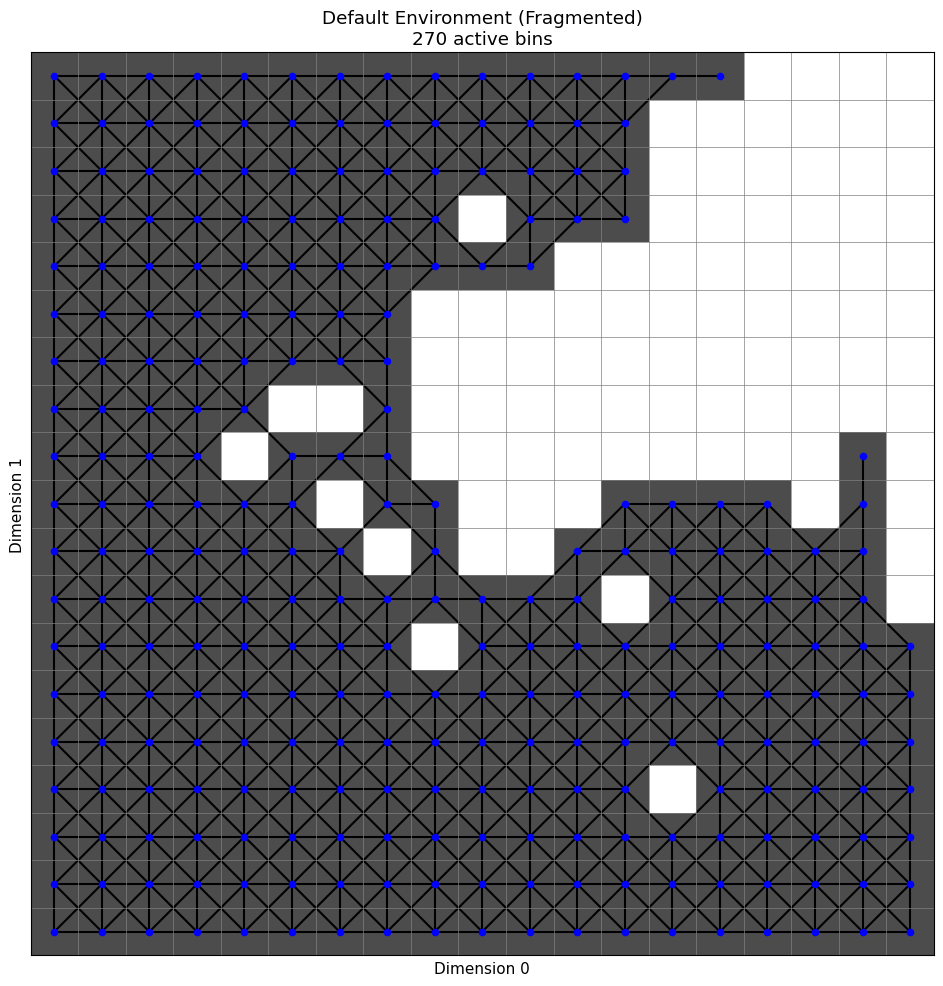


Problem: Environment is fragmented!
- Center bins are missing (animal rarely visited)
- Cannot compute paths through the center
- Spatial analysis will be limited to edges only


In [5]:
# Visualize the fragmented environment
fig, ax = plt.subplots(figsize=(10, 10))
env_default.plot(ax=ax, show_connectivity=True)
ax.set_title(f"Default Environment (Fragmented)\n{env_default.n_bins} active bins")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

print("\nProblem: Environment is fragmented!")
print("- Center bins are missing (animal rarely visited)")
print("- Cannot compute paths through the center")
print("- Spatial analysis will be limited to edges only")

### Checking Connectivity

Let's verify that the environment is indeed disconnected:

In [6]:
import networkx as nx

# Check if environment is connected
is_connected = nx.is_connected(env_default.connectivity)
print(f"Is environment connected? {is_connected}")

if not is_connected:
    # Find connected components
    components = list(nx.connected_components(env_default.connectivity))
    print(f"\nNumber of disconnected components: {len(components)}")
    print(f"Largest component size: {len(max(components, key=len))} bins")
    print(f"Smallest component size: {len(min(components, key=len))} bins")

    # Try to find a path from corner to corner (will fail if disconnected)
    try:
        corner1 = env_default.bin_at([[10, 10]])[0]
        corner2 = env_default.bin_at([[90, 90]])[0]
        path = env_default.path_between(corner1, corner2)
        print(f"\nPath from corner to corner: {len(path)} bins")
    except nx.NetworkXNoPath:
        print("\nNo path exists between opposite corners!")

Is environment connected? True


## Solution 1: Morphological Dilation

**Dilation** expands active regions by adding neighboring bins. This fills small gaps and connects nearby fragments.

Think of it like inflating the active region slightly.

In [7]:
# Create environment with dilation
env_dilated = Environment.from_samples(
    positions=sparse_data,
    bin_size=5.0,
    dilate=True,  # Enable dilation
    name="Dilated",
)

print(env_dilated.info())
print(f"\nBins added by dilation: {env_dilated.n_bins - env_default.n_bins}")

Environment Information

Name: Dilated
Layout Type: RegularGrid
Dimensions: 2
Number of Bins: 315

Spatial Extent:
  Dimension 0: [2.50, 97.50] (range: 95.00)
  Dimension 1: [2.50, 97.50] (range: 95.00)

Bin Sizes:
  Dimension 0: 5.00
  Dimension 1: 5.00

Regions: None


Bins added by dilation: 45


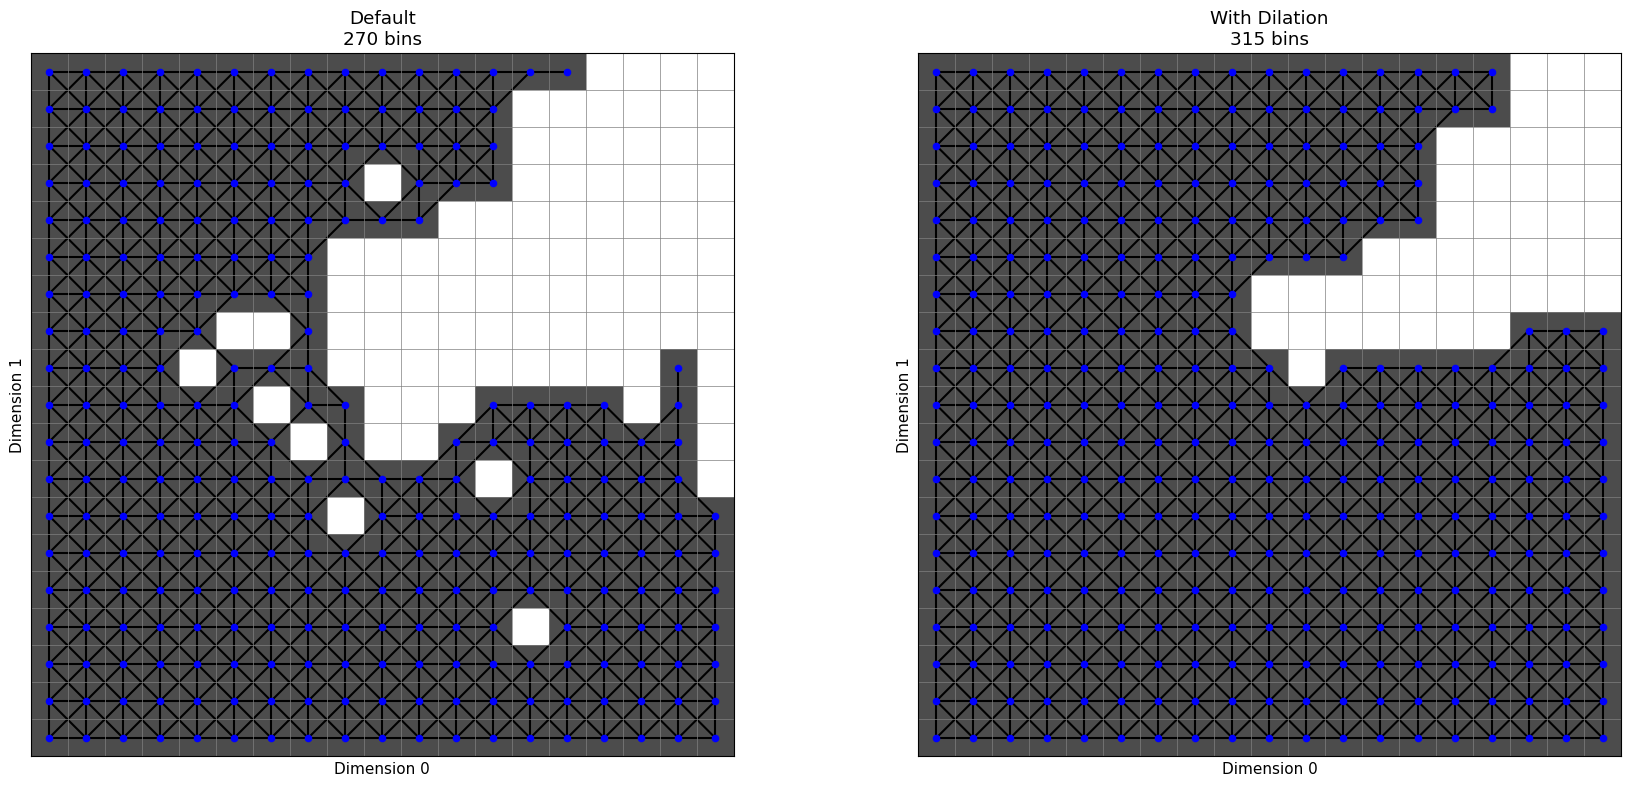


Is dilated environment connected? True


In [8]:
# Compare default vs dilated
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

env_default.plot(ax=axes[0], show_connectivity=True)
axes[0].set_title(f"Default\n{env_default.n_bins} bins")
axes[0].set_aspect("equal")

env_dilated.plot(ax=axes[1], show_connectivity=True)
axes[1].set_title(f"With Dilation\n{env_dilated.n_bins} bins")
axes[1].set_aspect("equal")

plt.tight_layout()
plt.show()

# Check connectivity
is_connected = nx.is_connected(env_dilated.connectivity)
print(f"\nIs dilated environment connected? {is_connected}")

## Solution 2: Filling Holes

**Fill holes** fills in completely enclosed inactive regions. This is useful when an animal briefly crosses an area but doesn't sample it well enough to activate all bins.

In [9]:
# Create environment with hole filling
env_filled = Environment.from_samples(
    positions=sparse_data,
    bin_size=5.0,
    fill_holes=True,  # Enable hole filling
    name="Filled",
)

print(env_filled.info())
print(f"\nBins added by fill_holes: {env_filled.n_bins - env_default.n_bins}")

Environment Information

Name: Filled
Layout Type: RegularGrid
Dimensions: 2
Number of Bins: 279

Spatial Extent:
  Dimension 0: [2.50, 97.50] (range: 95.00)
  Dimension 1: [2.50, 97.50] (range: 95.00)

Bin Sizes:
  Dimension 0: 5.00
  Dimension 1: 5.00

Regions: None


Bins added by fill_holes: 9


## Solution 3: Closing Gaps

**Close gaps** performs dilation followed by erosion (shrinking). This connects nearby regions while preserving the overall shape better than dilation alone.

Think of it as: expand -> connect -> shrink back to original size.

In [10]:
# Create environment with gap closing
env_closed = Environment.from_samples(
    positions=sparse_data,
    bin_size=5.0,
    close_gaps=True,  # Enable closing
    name="Closed",
)

print(env_closed.info())
print(
    f"\nBins after close_gaps: {env_closed.n_bins} (compare to {env_default.n_bins} default)"
)

Environment Information

Name: Closed
Layout Type: RegularGrid
Dimensions: 2
Number of Bins: 225

Spatial Extent:
  Dimension 0: [2.50, 97.50] (range: 95.00)
  Dimension 1: [2.50, 97.50] (range: 95.00)

Bin Sizes:
  Dimension 0: 5.00
  Dimension 1: 5.00

Regions: None


Bins after close_gaps: 225 (compare to 270 default)


## Combining Multiple Operations

For very sparse data, you can combine multiple morphological operations:

In [11]:
# Combine all operations
env_combined = Environment.from_samples(
    positions=sparse_data,
    bin_size=5.0,
    dilate=True,
    fill_holes=True,
    close_gaps=True,
    name="Combined",
)

print(env_combined.info())

Environment Information

Name: Combined
Layout Type: RegularGrid
Dimensions: 2
Number of Bins: 311

Spatial Extent:
  Dimension 0: [2.50, 97.50] (range: 95.00)
  Dimension 1: [2.50, 97.50] (range: 95.00)

Bin Sizes:
  Dimension 0: 5.00
  Dimension 1: 5.00

Regions: None



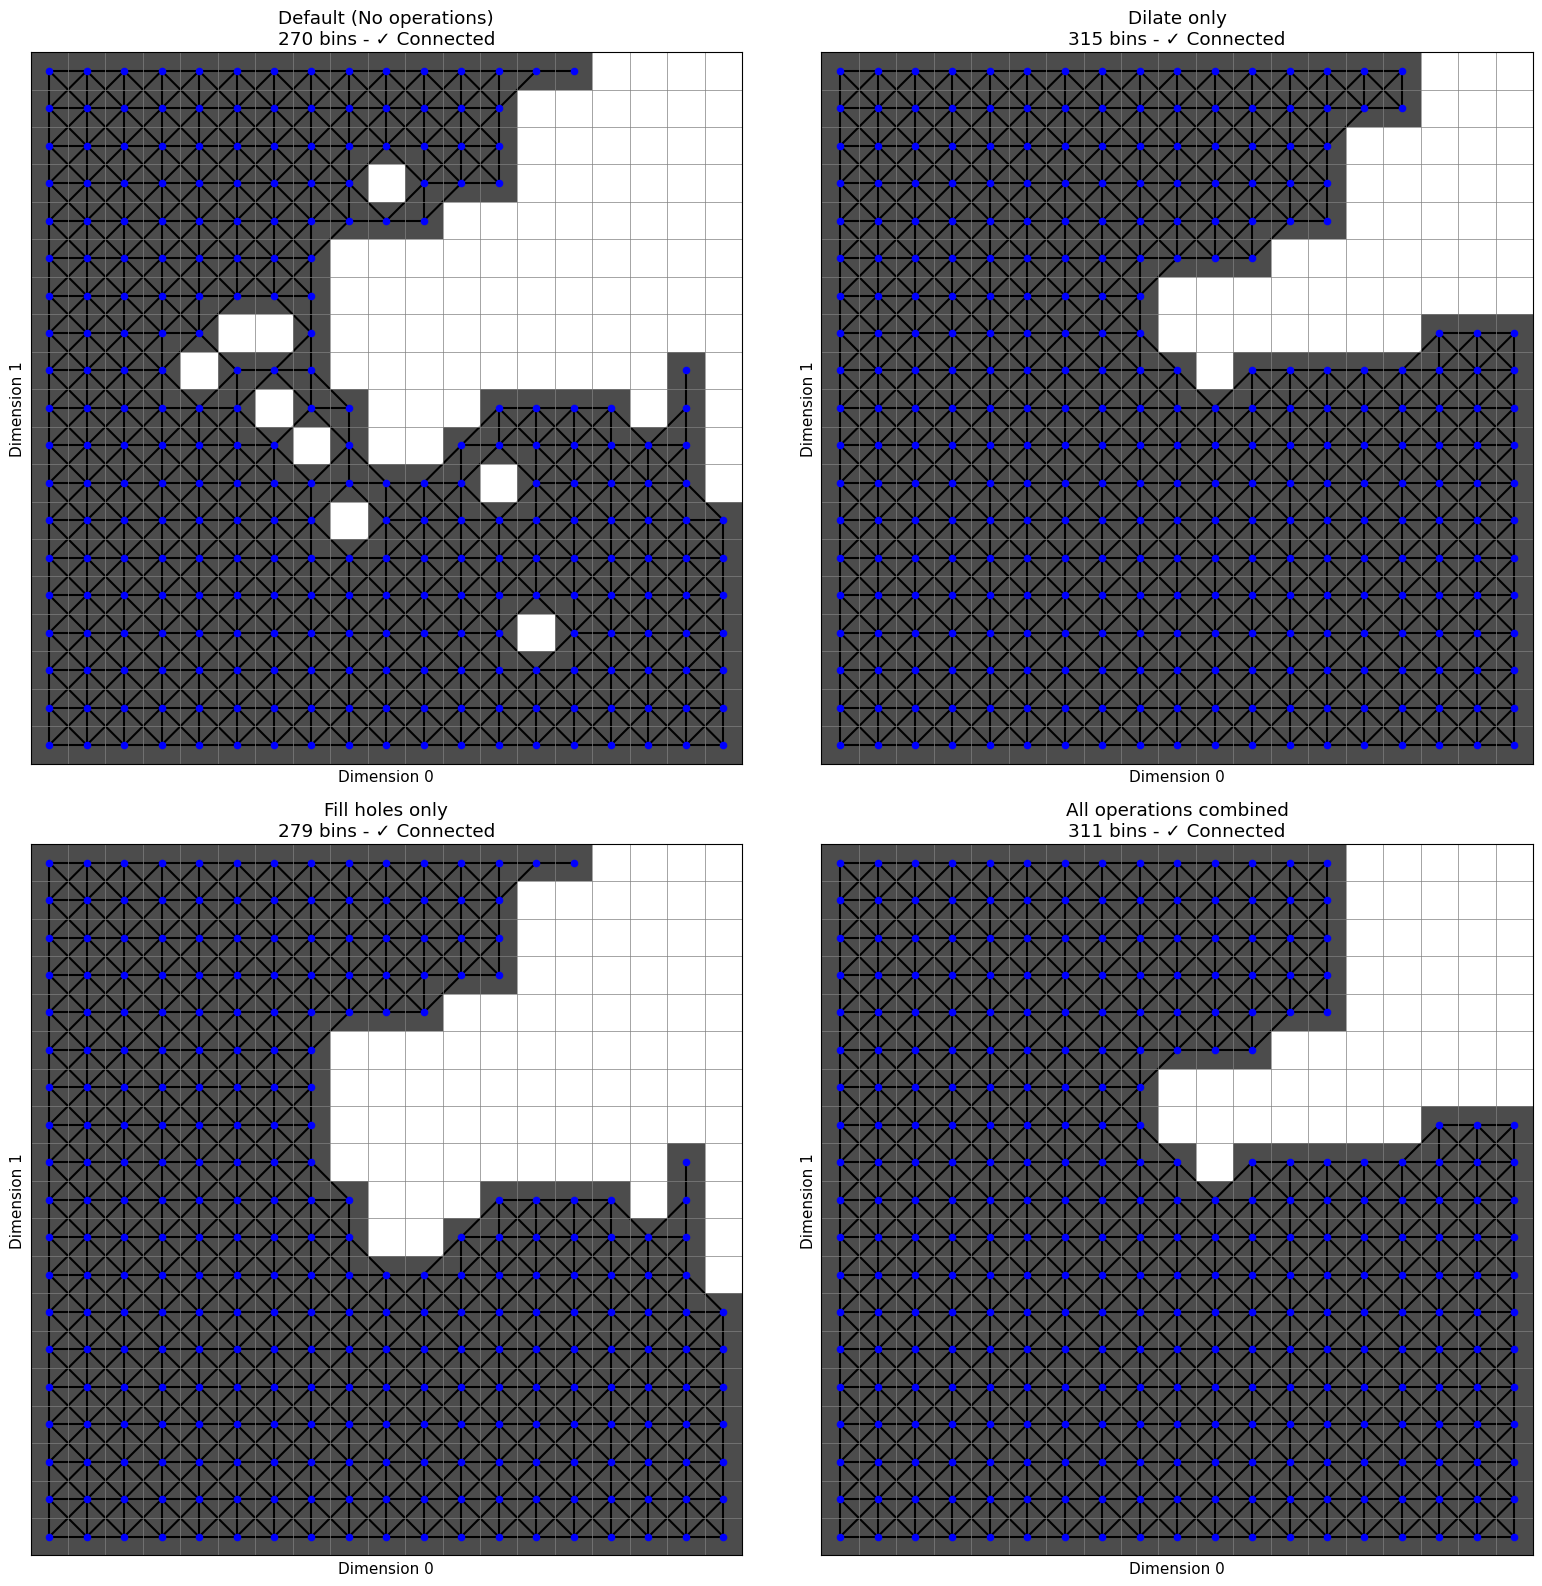

In [12]:
# Compare all approaches
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.ravel()

envs = [
    (env_default, "Default (No operations)"),
    (env_dilated, "Dilate only"),
    (env_filled, "Fill holes only"),
    (env_combined, "All operations combined"),
]

for ax, (env, title) in zip(axes, envs, strict=False):
    env.plot(ax=ax, show_connectivity=True)

    # Check connectivity
    is_connected = nx.is_connected(env.connectivity)
    status = "✓ Connected" if is_connected else "✗ Disconnected"

    ax.set_title(f"{title}\n{env.n_bins} bins - {status}")
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()

## Solution 4: Adjusting bin_count_threshold

By default, a bin needs at least 1 sample to be considered active. You can adjust this threshold to:

- **Lower threshold (< 1)**: Include bins with sparse sampling
- **Higher threshold (> 1)**: Require more samples for robust estimates

**Note**: `bin_count_threshold` is applied BEFORE morphological operations.

In [13]:
# Compare different thresholds
thresholds = [1, 5, 10]
env_thresholds = {}

for thresh in thresholds:
    env = Environment.from_samples(
        positions=sparse_data,
        bin_size=5.0,
        bin_count_threshold=thresh,
        name=f"Threshold_{thresh}",
    )
    env_thresholds[thresh] = env
    print(f"Threshold = {thresh}: {env.n_bins} active bins")

Threshold = 1: 248 active bins
Threshold = 5: 172 active bins
Threshold = 10: 100 active bins


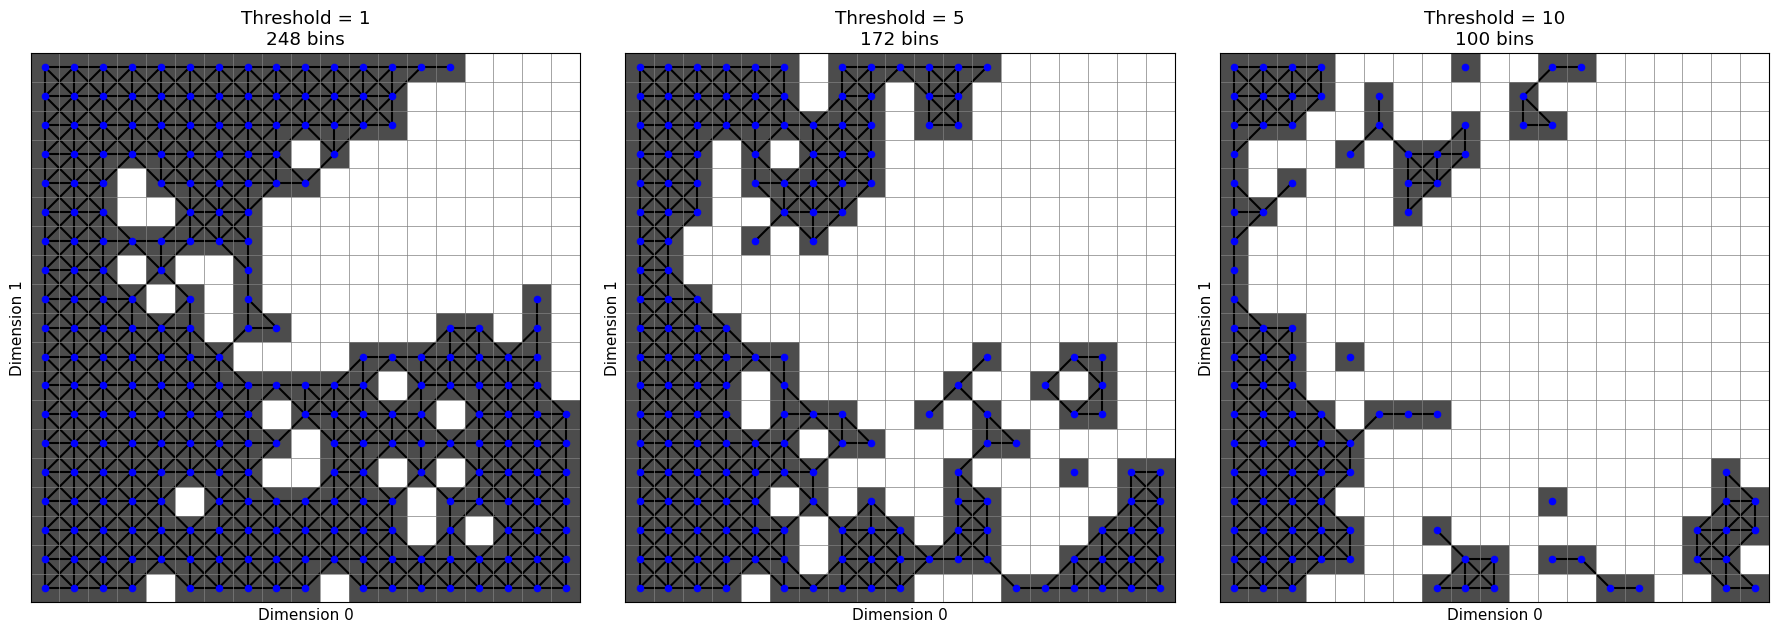


Higher thresholds remove bins with sparse sampling
Use this to focus on well-sampled regions only


In [14]:
# Visualize threshold effects
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, thresh in zip(axes, thresholds, strict=False):
    env_thresholds[thresh].plot(ax=ax, show_connectivity=True)
    ax.set_title(f"Threshold = {thresh}\n{env_thresholds[thresh].n_bins} bins")
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()

print("\nHigher thresholds remove bins with sparse sampling")
print("Use this to focus on well-sampled regions only")

## Practical Example: Fixing a Real Analysis Pipeline

Let's simulate a complete analysis workflow where sparse data causes problems, then fix it.

In [15]:
# Simulate neural spiking data correlated with position
def generate_place_cell_spikes(position, preferred_location, field_size=15.0):
    """
    Generate spikes from a place cell with a preferred location.

    Parameters
    ----------
    position : ndarray, shape (n_samples, 2)
        Position trajectory.
    preferred_location : array-like, shape (2,)
        Center of place field.
    field_size : float
        Spatial scale of place field.

    Returns
    -------
    spike_counts : ndarray, shape (n_samples,)
        Number of spikes at each timepoint.
    """
    distances = np.linalg.norm(position - preferred_location, axis=1)
    firing_rate = 20.0 * np.exp(
        -(distances**2) / (2 * field_size**2)
    )  # Gaussian place field

    # Poisson spiking
    dt = 0.05  # 50 ms bins
    spike_counts = np.random.poisson(firing_rate * dt)
    return spike_counts


# Create place cell centered in the arena
place_field_center = np.array([50.0, 50.0])
spikes = generate_place_cell_spikes(sparse_data, place_field_center, field_size=20.0)

print(f"Generated {spikes.sum()} total spikes")
print(f"Mean firing rate: {spikes.mean() / 0.05:.2f} Hz")

Generated 421 total spikes
Mean firing rate: 2.95 Hz


### Problem: Computing Spatial Firing Rate Map

With the fragmented default environment, we can't compute rates for center bins:

In [16]:
# Map spikes to bins
bin_indices = env_default.bin_at(sparse_data)

# Count spikes per bin
spike_counts_per_bin = np.bincount(
    bin_indices[bin_indices >= 0],
    weights=spikes[bin_indices >= 0],
    minlength=env_default.n_bins,
)

# Count occupancy per bin (in seconds)
occupancy_per_bin = (
    np.bincount(bin_indices[bin_indices >= 0], minlength=env_default.n_bins) * 0.05
)  # 50 ms per sample

# Compute firing rate (spikes / seconds)
# Add small epsilon to avoid division by zero
firing_rate_map = np.divide(
    spike_counts_per_bin,
    occupancy_per_bin,
    where=occupancy_per_bin > 0,
    out=np.zeros_like(spike_counts_per_bin, dtype=float),
)

print(
    f"Bins with valid firing rates: {np.sum(firing_rate_map > 0)} / {env_default.n_bins}"
)
print(f"Peak firing rate: {firing_rate_map.max():.2f} Hz")
print("\nProblem: Center bins have no data (firing rate = 0)")

Bins with valid firing rates: 162 / 270
Peak firing rate: 40.00 Hz

Problem: Center bins have no data (firing rate = 0)


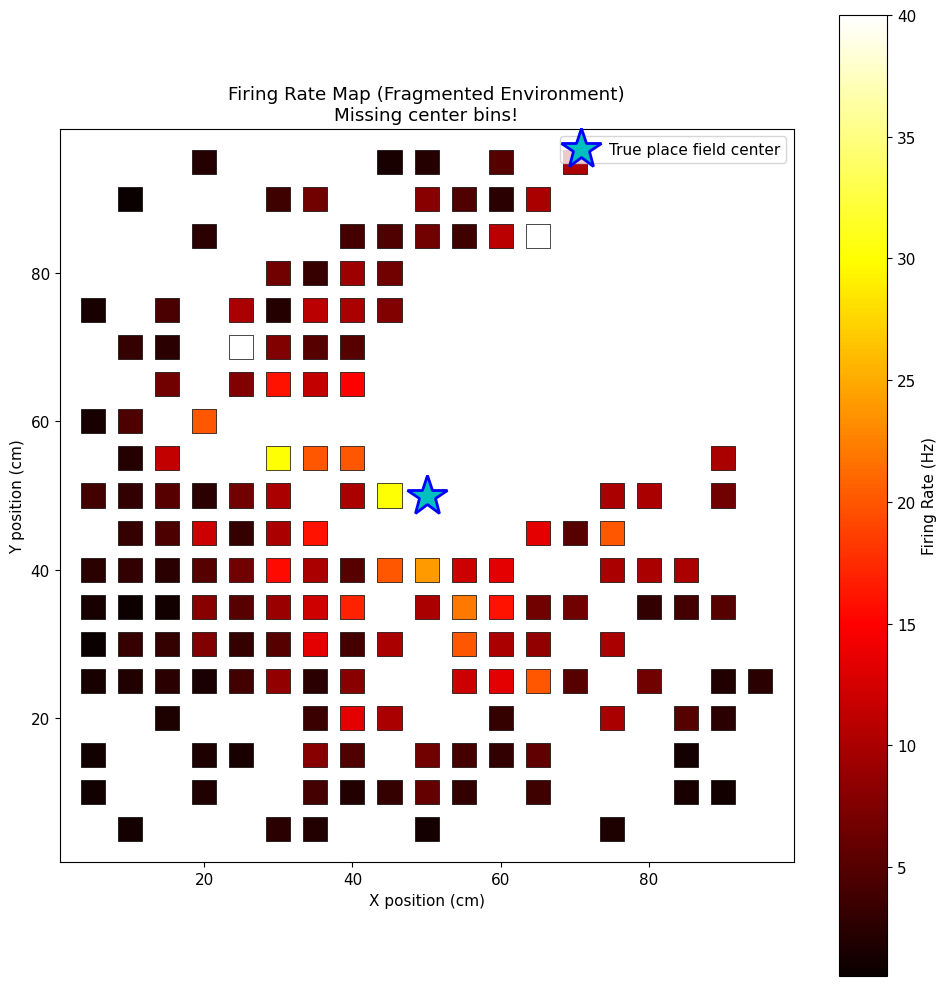

In [17]:
# Visualize problematic firing rate map
fig, ax = plt.subplots(figsize=(10, 10))

# Only plot bins with data
active_bins = firing_rate_map > 0
scatter = ax.scatter(
    env_default.bin_centers[active_bins, 0],
    env_default.bin_centers[active_bins, 1],
    c=firing_rate_map[active_bins],
    s=300,
    cmap="hot",
    marker="s",
    edgecolors="black",
    linewidth=0.5,
)

# Mark true place field center
ax.plot(
    place_field_center[0],
    place_field_center[1],
    "c*",
    markersize=30,
    markeredgecolor="blue",
    markeredgewidth=2,
    label="True place field center",
)

ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Firing Rate Map (Fragmented Environment)\nMissing center bins!")
ax.set_aspect("equal")
ax.legend()
plt.colorbar(scatter, ax=ax, label="Firing Rate (Hz)")
plt.tight_layout()
plt.show()

### Solution: Use Morphological Operations

Now let's fix this by creating a properly connected environment:

In [18]:
# Create fixed environment
env_fixed = Environment.from_samples(
    positions=sparse_data, bin_size=5.0, dilate=True, fill_holes=True, name="Fixed"
)

print(f"Fixed environment: {env_fixed.n_bins} bins")
print(f"Is connected: {nx.is_connected(env_fixed.connectivity)}")

# Recompute firing rate map
bin_indices_fixed = env_fixed.bin_at(sparse_data)

spike_counts_per_bin_fixed = np.bincount(
    bin_indices_fixed[bin_indices_fixed >= 0],
    weights=spikes[bin_indices_fixed >= 0],
    minlength=env_fixed.n_bins,
)

occupancy_per_bin_fixed = (
    np.bincount(bin_indices_fixed[bin_indices_fixed >= 0], minlength=env_fixed.n_bins)
    * 0.05
)

firing_rate_map_fixed = np.divide(
    spike_counts_per_bin_fixed,
    occupancy_per_bin_fixed,
    where=occupancy_per_bin_fixed > 0,
    out=np.zeros_like(spike_counts_per_bin_fixed, dtype=float),
)

print(
    f"\nBins with valid firing rates: {np.sum(firing_rate_map_fixed > 0)} / {env_fixed.n_bins}"
)

Fixed environment: 315 bins
Is connected: True

Bins with valid firing rates: 162 / 315


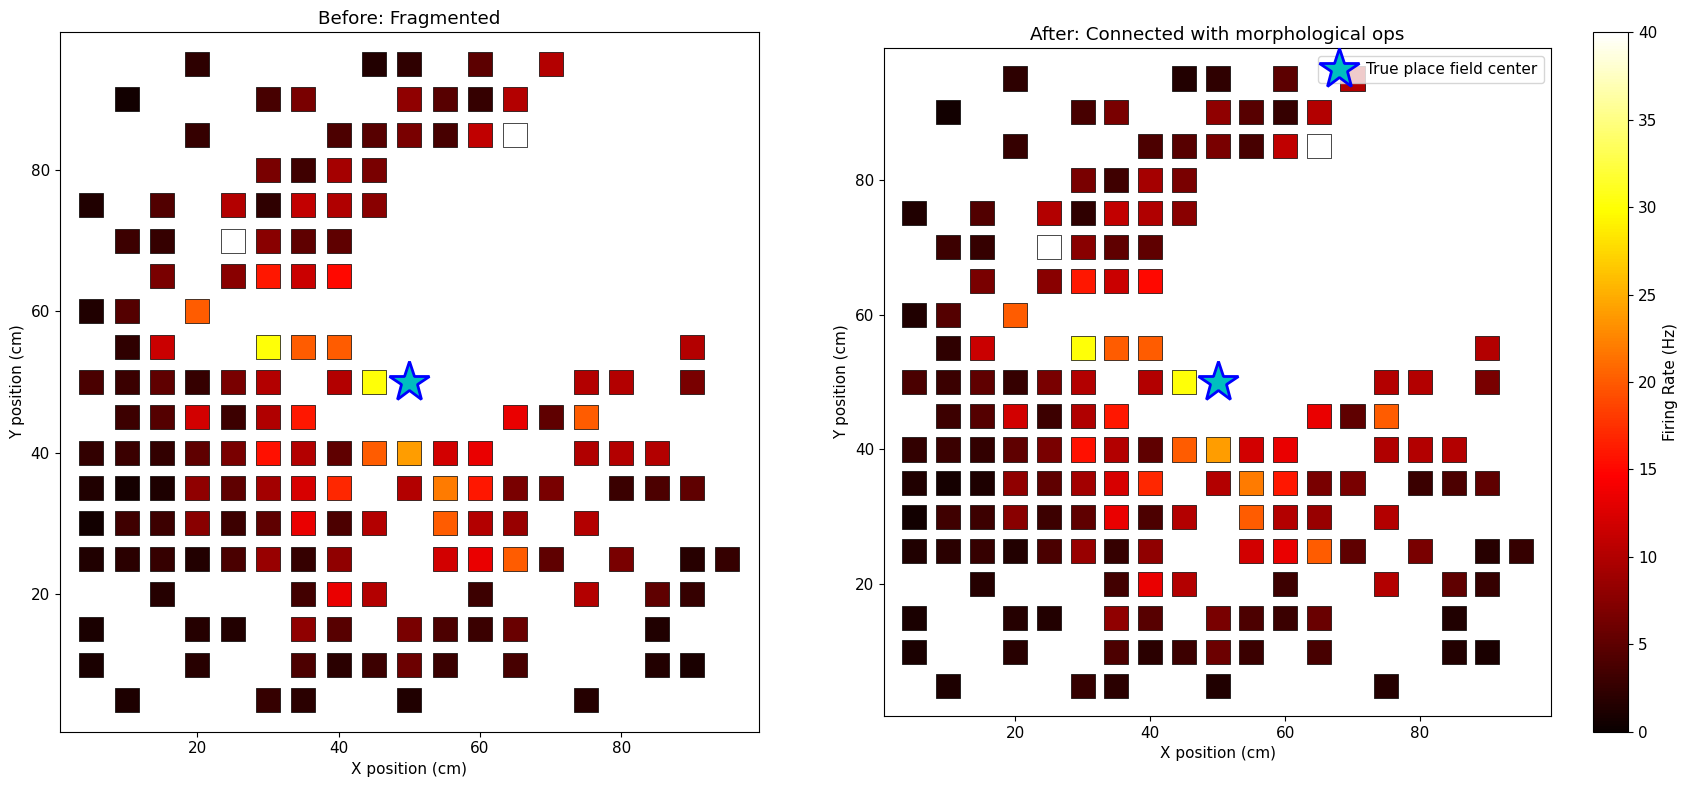


Fixed! Now we can see the complete place field


In [19]:
# Visualize fixed firing rate map
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Before
active_bins = firing_rate_map > 0
scatter1 = axes[0].scatter(
    env_default.bin_centers[active_bins, 0],
    env_default.bin_centers[active_bins, 1],
    c=firing_rate_map[active_bins],
    s=300,
    cmap="hot",
    vmin=0,
    vmax=firing_rate_map.max(),
    marker="s",
    edgecolors="black",
    linewidth=0.5,
)
axes[0].plot(
    place_field_center[0],
    place_field_center[1],
    "c*",
    markersize=30,
    markeredgecolor="blue",
    markeredgewidth=2,
)
axes[0].set_title("Before: Fragmented")
axes[0].set_aspect("equal")
axes[0].set_xlabel("X position (cm)")
axes[0].set_ylabel("Y position (cm)")

# After
active_bins_fixed = firing_rate_map_fixed > 0
scatter2 = axes[1].scatter(
    env_fixed.bin_centers[active_bins_fixed, 0],
    env_fixed.bin_centers[active_bins_fixed, 1],
    c=firing_rate_map_fixed[active_bins_fixed],
    s=300,
    cmap="hot",
    vmin=0,
    vmax=firing_rate_map.max(),
    marker="s",
    edgecolors="black",
    linewidth=0.5,
)
axes[1].plot(
    place_field_center[0],
    place_field_center[1],
    "c*",
    markersize=30,
    markeredgecolor="blue",
    markeredgewidth=2,
    label="True place field center",
)
axes[1].set_title("After: Connected with morphological ops")
axes[1].set_aspect("equal")
axes[1].set_xlabel("X position (cm)")
axes[1].set_ylabel("Y position (cm)")
axes[1].legend()

plt.colorbar(scatter2, ax=axes[1], label="Firing Rate (Hz)")
plt.tight_layout()
plt.show()

print("\nFixed! Now we can see the complete place field")

## When to Use Each Operation

Here's a decision guide:

| Operation | Use When | Effect | Caution |
|-----------|----------|--------|--------|
| **dilate** | Sparse sampling, need connectivity | Expands active regions by 1 bin | Adds bins where animal never went |
| **fill_holes** | Animal crosses regions quickly | Fills enclosed gaps | Only affects interior holes |
| **close_gaps** | Need to connect nearby fragments | Connects then shrinks | Better shape preservation than dilate |
| **bin_count_threshold** | Very sparse data or need robust estimates | Removes bins with few samples | May fragment more |

**General recommendation:**
1. Start without morphological operations
2. Check if environment is connected (use `networkx.is_connected()`)
3. If fragmented, try `dilate=True` first
4. If still fragmented, add `fill_holes=True`
5. Only use higher `bin_count_threshold` if you need very robust estimates

## Common Pitfalls

### Pitfall 1: Over-dilation

Too much dilation can create bins far from actual data:

In [20]:
# Multiple rounds of dilation
env_over_dilated = Environment.from_samples(
    positions=sparse_data, bin_size=5.0, dilate=True, name="OverDilated"
)

# Apply dilation multiple times manually (not recommended!)
# This is just for demonstration
print("Warning: Don't dilate multiple times unless you have a good reason!")
print("Morphological operations should be used conservatively.")


Morphological operations should be used conservatively.


### Pitfall 2: Wrong operation order

Operations are applied in this order:
1. bin_count_threshold (determines initial active bins)
2. dilate
3. fill_holes
4. close_gaps

This order matters for the final result!

### Pitfall 3: Forgetting to check connectivity

Always verify your environment is connected before computing spatial paths or distances:

In [21]:
def check_environment_quality(env):
    """
    Diagnostic function to check environment quality.

    Parameters
    ----------
    env : Environment
        Environment to check.
    """
    print(f"Environment: {env.name}")
    print(f"  Total bins: {env.n_bins}")
    print(f"  Total edges: {env.connectivity.number_of_edges()}")

    is_connected = nx.is_connected(env.connectivity)
    print(f"  Connected: {is_connected}")

    if not is_connected:
        components = list(nx.connected_components(env.connectivity))
        print(f"  WARNING: {len(components)} disconnected components!")
        print(f"  Largest component: {len(max(components, key=len))} bins")

    print()


# Check all our environments
check_environment_quality(env_default)
check_environment_quality(env_fixed)

Environment: Default_Sparse
  Total bins: 270
  Total edges: 912
  Connected: True

Environment: Fixed
  Total bins: 315
  Total edges: 1128
  Connected: True



### Pitfall 4: Not considering the trade-off

Morphological operations make connectivity better but:
- Add bins where the animal never went
- Can't compute occupancy-normalized rates for these bins
- May artificially smooth spatial patterns

**Best practice**: Use morphological operations to establish connectivity, but mark these bins in your analysis and interpret carefully.

## Key Takeaways

1. **Real data is sparse** - Animals don't sample uniformly, tracking can fail
2. **Fragmentation breaks analyses** - Disconnected environments can't compute paths or distances
3. **Morphological operations fix connectivity**:
   - `dilate=True` - Expand active regions
   - `fill_holes=True` - Fill enclosed gaps
   - `close_gaps=True` - Connect nearby fragments
4. **bin_count_threshold** - Control minimum samples needed per bin
5. **Always check connectivity** - Use `networkx.is_connected()` to verify
6. **Trade-offs exist** - More connectivity = more artificial bins
7. **Use conservatively** - Start minimal, add operations only if needed

## Next Steps

In the next notebook (**04_regions_of_interest.ipynb**), you'll learn:
- How to define named regions (goal locations, reward zones)
- Point vs polygon regions
- Querying spatial relationships
- Saving and loading region definitions

## Exercises (Optional)

1. Create extremely sparse data (remove 90% of samples) and find the minimal morphological operations needed
2. Compare firing rate maps with and without morphological operations
3. Find the optimal `bin_count_threshold` that gives you a connected environment
4. Create a diagnostic function that recommends which operations to use